In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification, make_blobs, make_gaussian_quantiles
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
import pdb
import time

## Utility functions

In [3]:
def plot_points(
    features,
    labels,
    xlim,
    ylim,
    ax=None,
    title=None,
    alpha=0.5,
    edgecolor="k",
    linewidths=None,
    marker="o",
):
    """ Scatter plot with class colored
    
    Parameters
    ----------
    features : array
        A numpy array of shape (x, 2) where x is the number of row
    labels : array
        A numpy array of shape (x,) of class index value
    xlim : list(float, float)
        x axis range from min to max
    ylim : list(float, float)
        y axis range from min to max
    ax : matplotlib.axes
        axes to plot on
    title : str (optional)
        The title of the plot
    alpha : float
        Ranging from 0 to 1, how transparent are the markers on the plot
    edgecolor : str
        color around the marker
    linewidths : scalar
        linewidth of the marker
    marker='o'
    """
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title(title, fontsize="medium")
    ax.scatter(
        features[:, 0],
        features[:, 1],
        c=labels,
        s=25,
        edgecolor=edgecolor,
        linewidths=linewidths,
        marker=marker,
        cmap=plt.cm.RdYlBu,
        alpha=alpha,
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax


def plot_decision_map(model, xlim, ylim, ax=None, mesh_size=0.02):
    """Create a decision boundary plot
    
    Parameters:
    -----------
    model: object
        a sklearn model
    xlim: list(float, float)
        the x axis limit to calculate the decision plot
    ylim: list(float, float)
        the y axis limit to calculate the decision plot
    ax : matplotlib.axes
        axes to plot on
    mesh_size: float
        what level of detail to plot the boundaries
    """
    if ax is None:
        _, ax = plt.subplots()

    xx, yy = np.meshgrid(np.arange(*xlim, mesh_size), np.arange(*ylim, mesh_size))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    return ax


def random_learning(labeled_idx, data, size):
    """Select unlabeled data points at random
    
    Parameter
    ---------
    labeled_idx : list-like
        index of data in training dataset
    data : array
        the whole dataset
    size : int
        number of indexes to return
        
    Return
    ------
    array
        the indexes of the new data
    """
    if size == 0:
        return np.empty((0), dtype=int)
    avail = set(range(len(data))).difference(labeled_idx)
    rs = np.random.RandomState(seed)  # FIX: got to be something better than this
    selected = rs.choice(list(avail), size=size, replace=False)
    return selected


def active_learning(labeled_idx, data, size, model, strategy_weight=[0.1, 0.8, 0.1]):
    """Select unlabled data points based on active learning strategy
    
    Parameter
    ---------
    labeled_idx : list-like
        index of data in training dataset
    data : array
        the whole data
    size : int
        number of indexes to return
    model : 
        trained model
    strategy_weight : list(float)
        how to distribute the proportion between [random, confidence, outlier] sampling
    
    Note
    ----
    Strategy (default)
    1. 10% random sampling which will call random_learning
    2. 80% confidence
    3. 10% outlier detection which is distance from culster center??
    """
    assert sum(strategy_weight) == 1, "Strategy Weight must sum up to 1.0"
    strategy_weight = [int(size * p) for p in strategy_weight]
    # to fix rounding
    strategy_weight[-1] = strategy_weight[-1] + (size - sum(strategy_weight))
    #     pdb.set_trace()
    random_idx = random_learning(labeled_idx, data, size=strategy_weight[0])
    confidence_idx = get_low_conf_unlabeled(
        np.concatenate([labeled_idx, random_idx]), data, strategy_weight[1], model
    )
    outlier_idx = get_outlier_unlabeled(
        np.concatenate([labeled_idx, random_idx, confidence_idx]),
        data,
        strategy_weight[2],
    )

    return [random_idx, confidence_idx, outlier_idx]


def get_low_conf_unlabeled(labeled_idx, data, size, model, limit=2_000):
    """Get top n indexs with the lowest margin of confidence 
    
    Parameter
    ---------
    labeled_idx : list-like
        the index in the training dataset
    data : array
        the whole data
    size : int
        number of indexes to return
    model : 
        trained model
    limit : int
        the number of data to predict on. For all data, use -1
    """
    if size == 0:
        return np.empty((0), dtype=int)
    assert size <= len(data), "Size is larger than data"
    avail = list(set(range(len(data))).difference(labeled_idx))
    confidences = []
    if limit != -1 and limit < len(avail):
        rs = np.random.RandomState(seed)  # FIX: got to be something better than this
        avail = rs.choice(avail, size=limit, replace=False)

    probs_best2 = model.predict_proba(data[avail])
    probs_best2.sort(axis=1)
    probs_best2 = probs_best2[:, -2:]
    confidence_margin = abs(probs_best2[:, 0] - probs_best2[:, 1])
    # select the smallest margin which means lack of confidence between top 2 classes
    sorted_idx = confidence_margin.argsort()[:size]

    return avail[sorted_idx]


def get_outlier_unlabeled(labeled_idx, data, size, limit=1_000):
    """Find top n index where features are furthest from training data
    
    Parameter
    ---------
    labeled_idx : list-like
        the index in the training dataset
    data : array
        the whole data
    size : int
        number of indexes to return
    limit : int
        the number of data to compute on. For all data, use -1
    
    Note
    ----
    The method is very basic which is finding the data with the largest difference between data points??? that doesn't work??
    I get the min?? distance between all data points? That is a lot. it will be m x n. I think it is fine for now. 

    """
    if size == 0:
        return np.empty((0), dtype=int)
    assert size <= len(data), "Size is larger than data"
    avail = list(set(range(len(data))).difference(labeled_idx))
    if limit != -1 and limit < len(avail):
        rs = np.random.RandomState(seed)  # FIX: got to be something better than this
        avail = rs.choice(avail, size=limit, replace=False)

    dist_pair = euclidean_distances(data[avail], data[labeled_idx])
    dist_min = dist_pair.min(axis=0)  # what is the closest point to itself
    dist_furthest_idx = dist_min.argsort()[-size:]

    return dist_furthest_idx


def plot_score(
    rand_scores, active_scores, best_score, max_iter, ylim, ax=None, title=None
):
    """Plot the model's running score with expected best value
    
    Parameter
    ---------
    rand_scores : list(float)
        model scores from random selection for each iterations
    active_scores : list(float)
        model scores from active selection for each iterations
    best_score : float
        the horizontal line
    max_iter : int
        the number of iterations the model will run
    ylim : list(int, int)
        set the y axis smallest and largest value
    ax : matpotlib.axes, optional
        which figure ot plot on
    title : str
        the title of the plot
    """
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(rand_scores, marker="o", label="Random Learning")
    ax.plot(active_scores, marker="o", label="Active Learning")
    ax.hlines(best_score, 0, max_iter, colors="r", label="Best Score")
    ax.set_ylim(*ylim)
    if title:
        ax.set_title(title)

    return ax

# Start here

In [4]:
n_samples = 10_000  # pretend that there are a lot of unlabel data
class_imbalance = [0.5, 0.23, 0.24, 0.03]
n_eval = int(
    n_samples * 0.5
)  # large number of samples for eval to calculate accurate performance
n_collect = 15  # how many time to collect data
n_start = 100  # minium data needed to start training, each label cost a lot to obtain
n_iter = 50  # samples collected per iteration, small value to model cost of each label
seed = 42
strategy_weight = [0.1, 0.8, 0.1]

(array([0, 1, 2, 3]), array([4989, 2296, 2397,  318]))
42


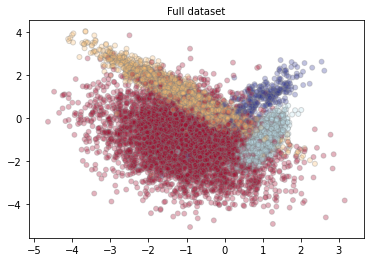

In [5]:
features, labels = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_classes=4,
    class_sep=1,
    weights=class_imbalance,
    n_clusters_per_class=1,
    random_state=seed,
)

print(np.unique(labels, return_counts=True))
print(seed)

# set axis range so each chart are consistent and are easy to compare
padding = 0.5
xlim = [features[:, 0].min() - padding, features[:, 0].max() + padding]
ylim = [features[:, 1].min() - padding, features[:, 1].max() + padding]

plot_points(
    features, labels, xlim, ylim, title="Full dataset", alpha=0.3, edgecolor="grey",
)
plt.show()

In [6]:
rs = np.random.RandomState(seed)
eval_idx = rs.choice(range(n_samples), size=n_eval, replace=False)
data_idx = np.setdiff1d(
    range(n_samples), eval_idx, assume_unique=True
)  # available data for training

## Best Score using all data available for training

Best Score using all 5,000 unlabeled data points: 0.8902


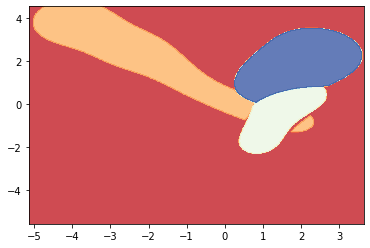

In [7]:
best_svc = SVC(gamma="auto", C=1)
best_svc = best_svc.fit(features[data_idx], labels[data_idx])
best_score = best_svc.score(features[eval_idx], labels[eval_idx])
print(f"Best Score using all {len(data_idx):,} unlabeled data points: {best_score}")
plot_decision_map(best_svc, xlim, ylim)
plt.show()

# Initiate 

In [8]:
def make_dashboard(random_data_highlights, active_data_highlights, curr_iter):
    # TODO: Need clean this function up. Duplicate code
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs = fig.add_gridspec(4, 6)

    #######################################################################
    plot_compare_score = fig.add_subplot(gs[0, :5])
    plot_score(
        rand_scores=random_score_ls,
        active_scores=active_score_ls,
        best_score=best_score,
        max_iter=n_collect,
        ylim=[min_score, best_score * 1.02],
        ax=plot_compare_score,
        title="Compare Learning",
    )
    plot_compare_score.set_ylabel("Mean Accuracy")
    plot_compare_score.set_xlabel("Epoch")
    plot_compare_score.legend(loc="lower right")

    ########################################################################
    plot_best = fig.add_subplot(gs[0, 5:])
    plot_decision_map(best_svc, xlim, ylim, ax=plot_best)
    plot_best.set_title("Best Model")
    plot_best.axis("off")

    #########################################################################

    plot_active_data = fig.add_subplot(gs[1:, :3])
    # Can only plot when model has been trained
    if curr_iter != 0:
        plot_decision_map(active_svc, xlim, ylim, ax=plot_active_data)
    plot_points(
        features[active_idx], labels[active_idx], xlim, ylim, ax=plot_active_data
    )
    active_data_highlights = np.concatenate(active_data_highlights)
    plot_points(
        features[active_data_highlights],
        labels[active_data_highlights],
        xlim,
        ylim,
        ax=plot_active_data,
        edgecolor="green",
        linewidths=3,
        alpha=1,
        title="Active Learning",
    )
    plot_active_data.get_xaxis().set_visible(False)
    plot_active_data.get_yaxis().set_visible(False)

    #######################################################################

    plot_random_data = fig.add_subplot(gs[1:, 3:])
    # Can only plot when model has been trained
    if curr_iter != 0:
        plot_decision_map(random_svc, xlim, ylim, ax=plot_random_data)
    plot_points(
        features[random_idx], labels[random_idx], xlim, ylim, ax=plot_random_data
    )
    plot_points(
        features[random_data_highlights],
        labels[random_data_highlights],
        xlim,
        ylim,
        ax=plot_random_data,
        edgecolor="green",
        linewidths=3,
        alpha=1,
        title="Random learning",
    )
    plot_random_data.get_xaxis().set_visible(False)
    plot_random_data.get_yaxis().set_visible(False)
    plt.show()

Starting with the same data points


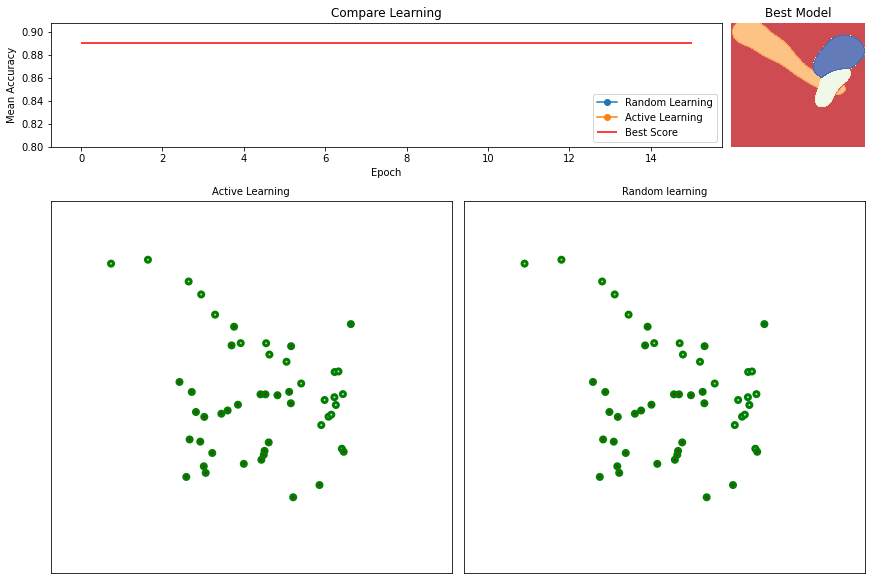

Iteration: 0 :: Act: 0.835 :: Rand: 0.835


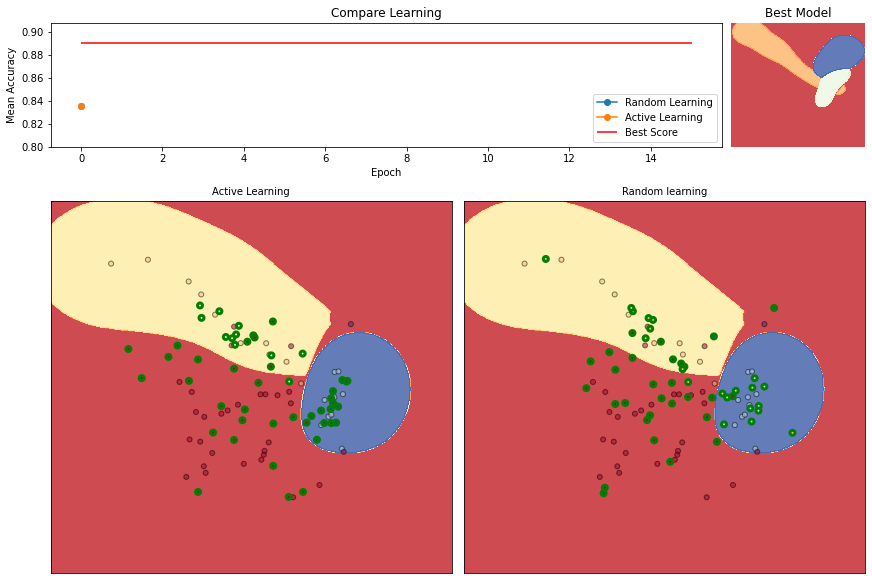

Iteration: 1 :: Act: 0.849 :: Rand: 0.846


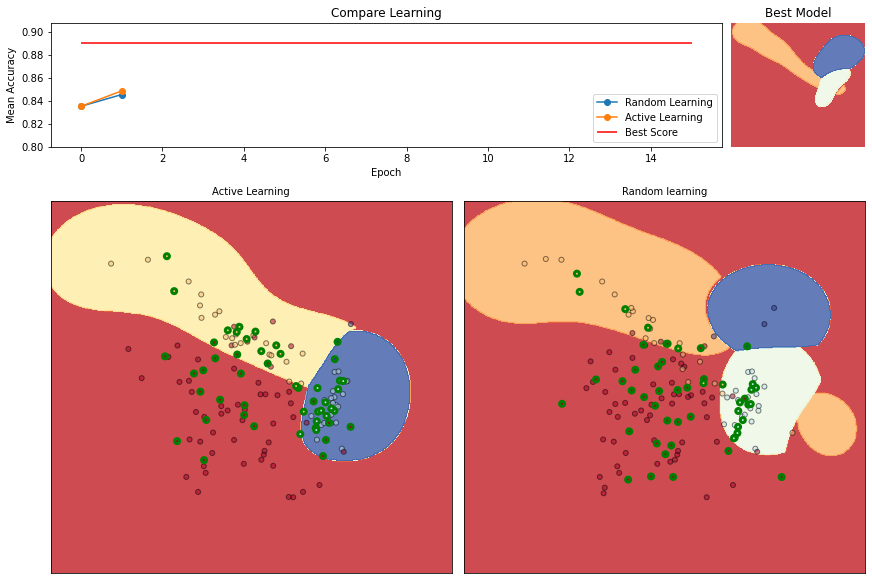

Iteration: 2 :: Act: 0.871 :: Rand: 0.832


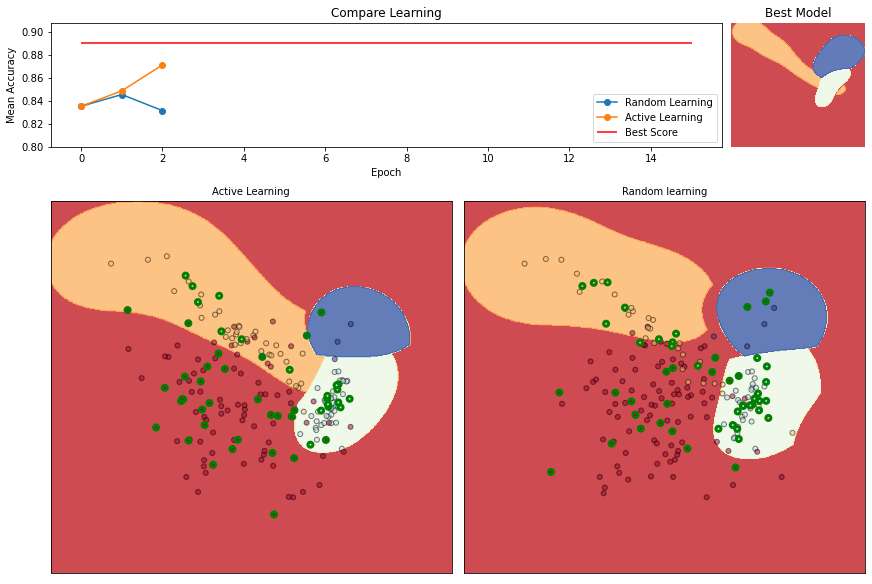

Iteration: 3 :: Act: 0.878 :: Rand: 0.852


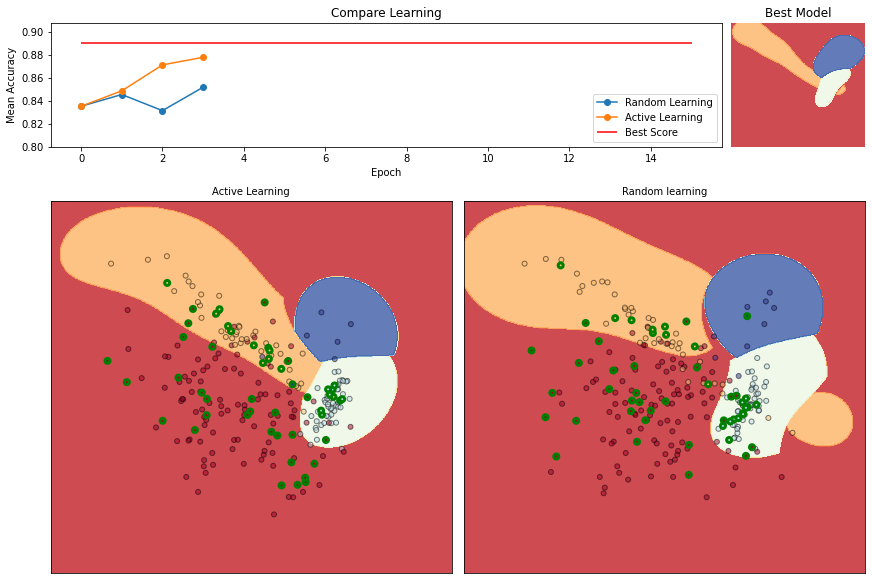

Iteration: 4 :: Act: 0.879 :: Rand: 0.858


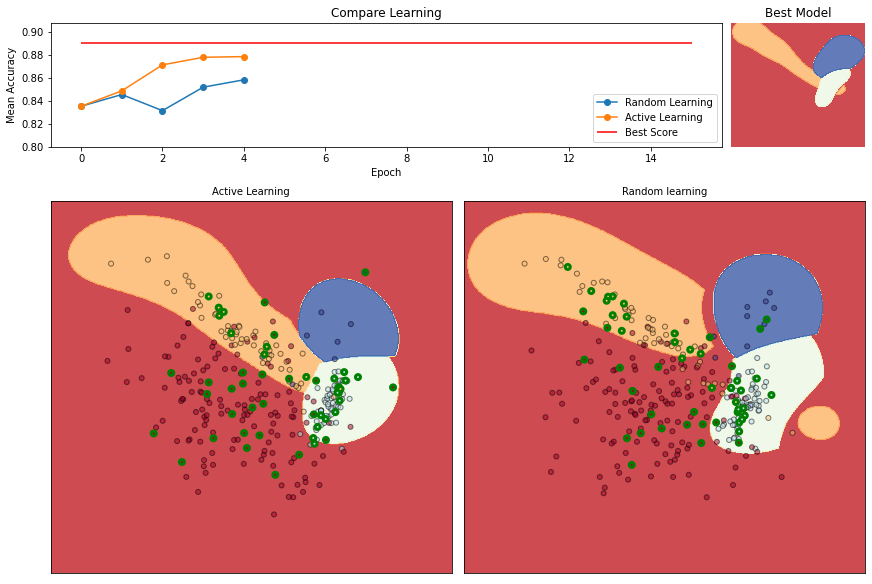

Iteration: 5 :: Act: 0.882 :: Rand: 0.868


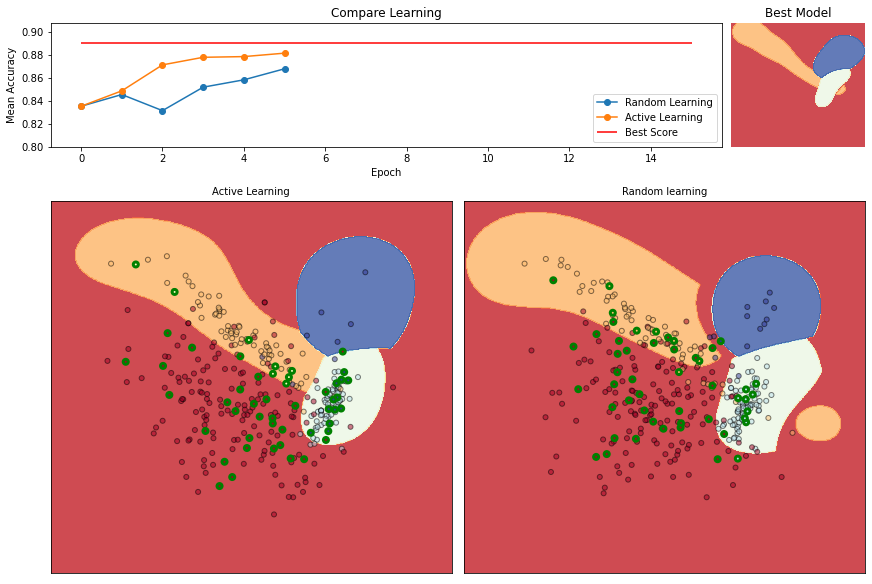

Iteration: 6 :: Act: 0.879 :: Rand: 0.866


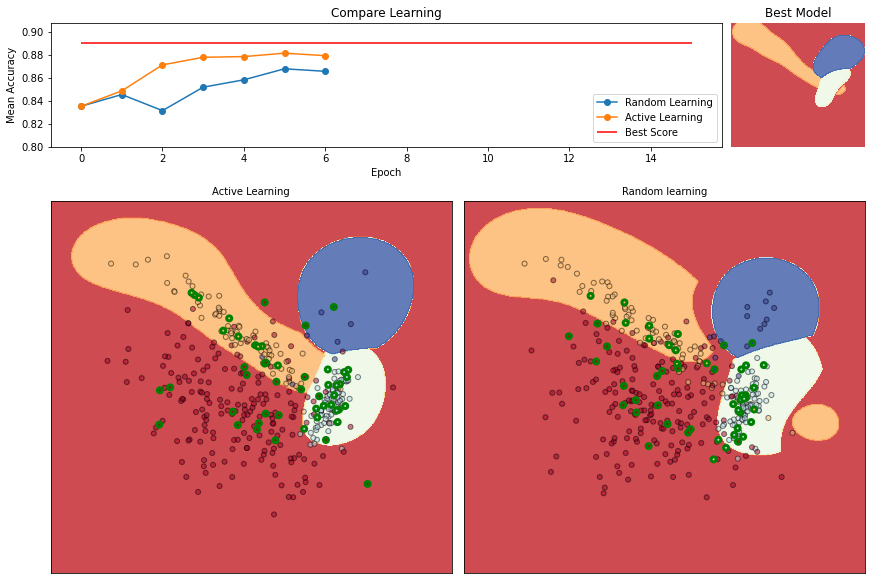

Iteration: 7 :: Act: 0.883 :: Rand: 0.872


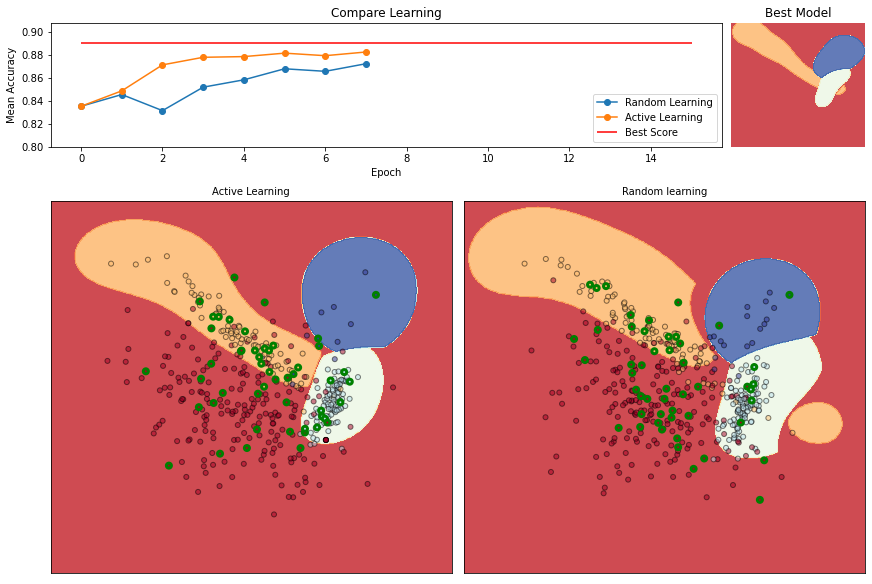

Iteration: 8 :: Act: 0.882 :: Rand: 0.872


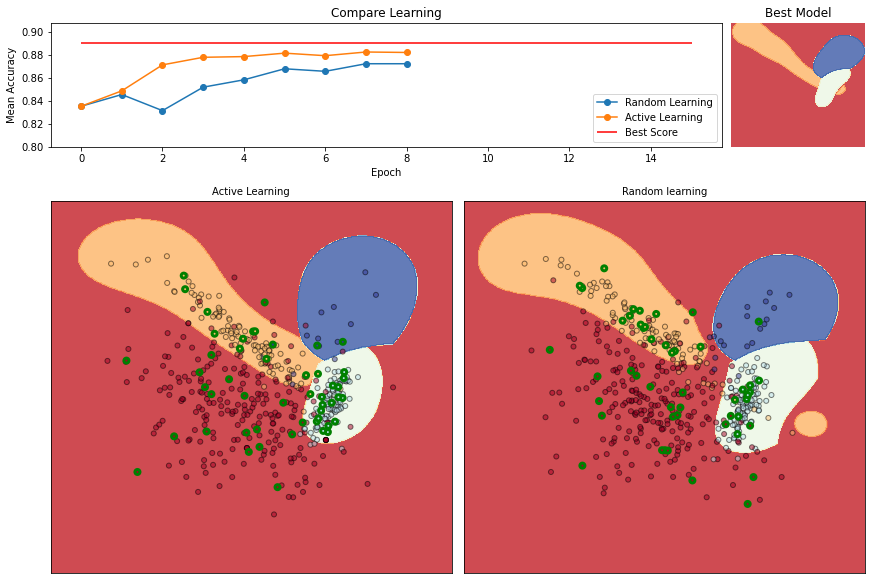

Iteration: 9 :: Act: 0.882 :: Rand: 0.879


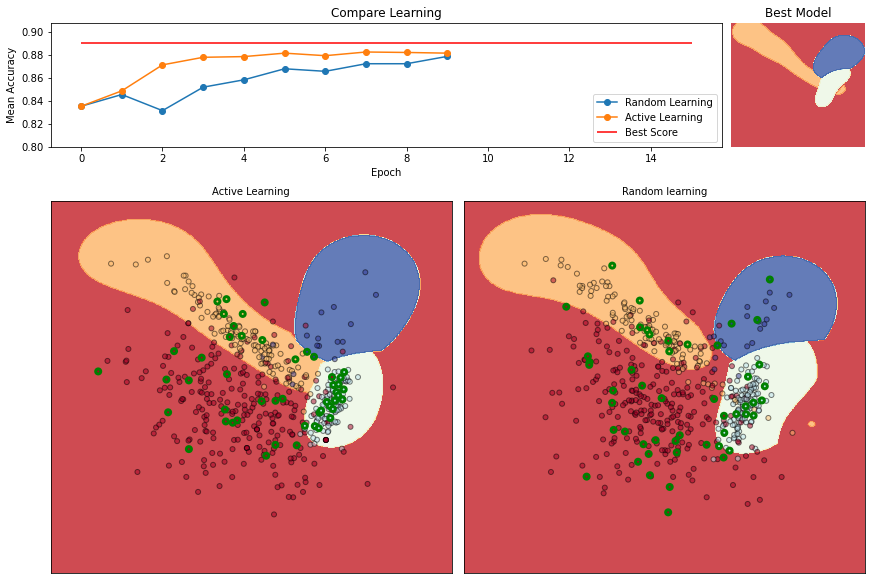

Iteration: 10 :: Act: 0.882 :: Rand: 0.880


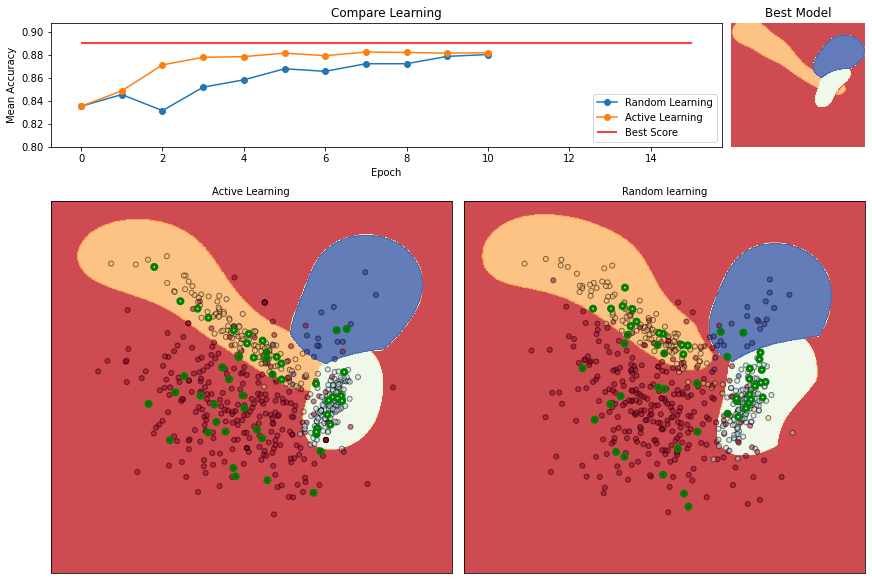

Iteration: 11 :: Act: 0.883 :: Rand: 0.882


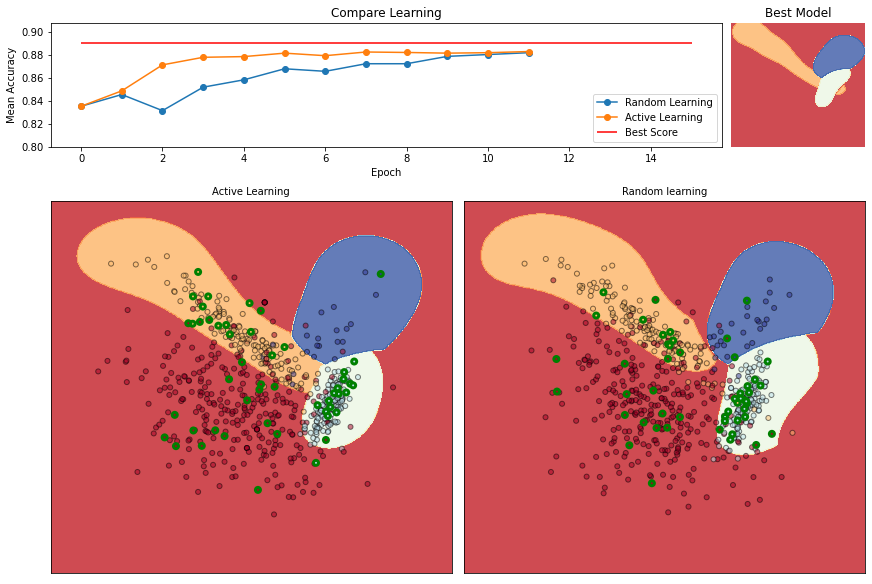

Iteration: 12 :: Act: 0.884 :: Rand: 0.880


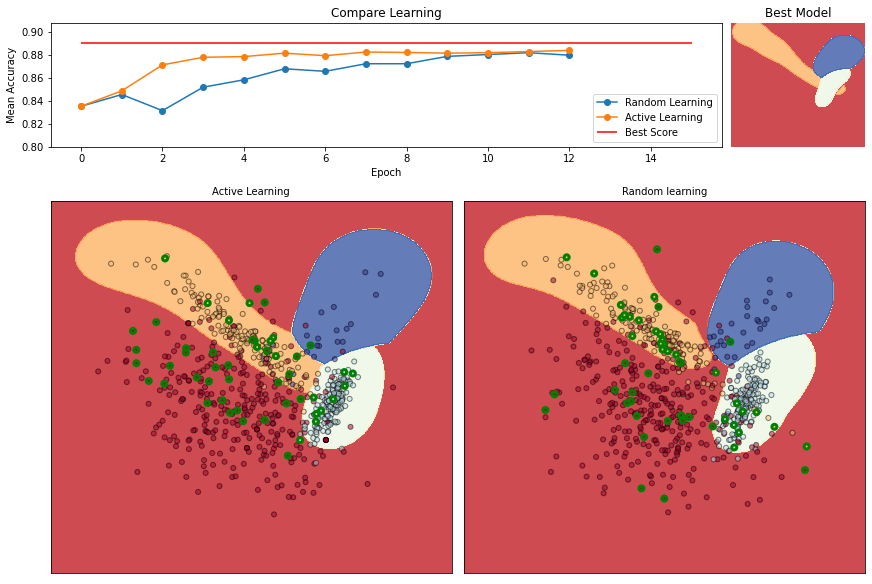

Iteration: 13 :: Act: 0.885 :: Rand: 0.880


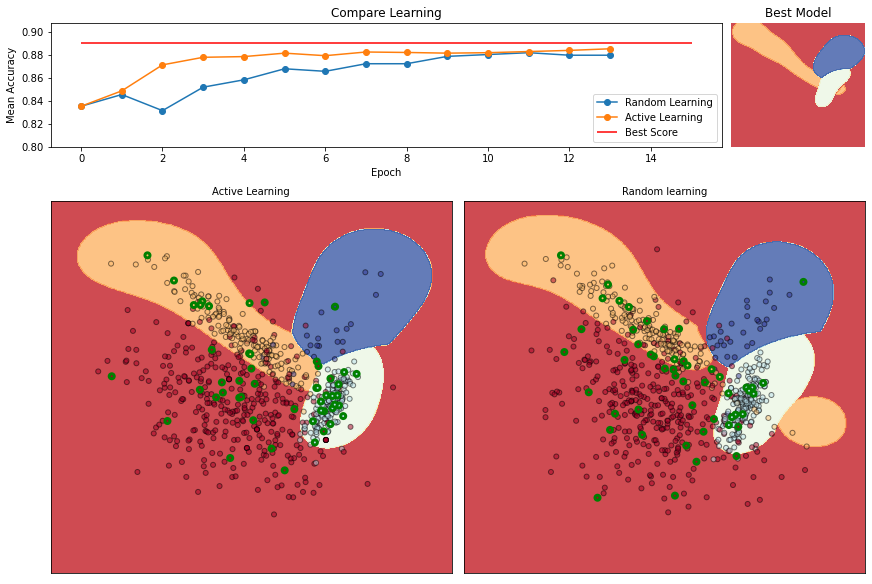

Iteration: 14 :: Act: 0.885 :: Rand: 0.884


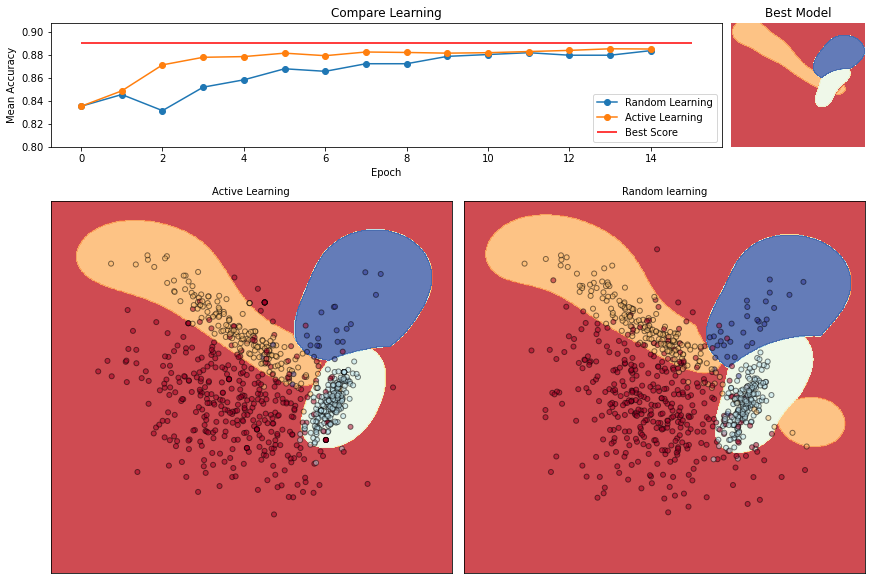

In [9]:
# iteration
random_svc = SVC(gamma="auto", C=1, probability=True)
active_svc = SVC(gamma="auto", C=1, probability=True)
random_idx = np.empty((0), dtype=int)
active_idx = np.empty((0), dtype=int)
random_score_ls, active_score_ls = [], []
min_score = 0.8  # FIX: this is hard coded
print("Starting with the same data points")
for i in range(n_collect):

    random_idx_new = random_learning(random_idx, features[data_idx], n_iter)
    random_idx = np.concatenate([random_idx, random_idx_new])

    if i == 0:
        active_idx = random_idx.copy()
        active_idx_new = [active_idx]
    else:
        active_idx_new = active_learning(
            active_idx,
            features[data_idx],
            n_iter,
            active_svc,
            strategy_weight=strategy_weight,
        )
        active_idx = np.concatenate([active_idx] + active_idx_new)

    assert len(active_idx) == len(random_idx)
    make_dashboard(random_idx_new, active_idx_new, i)

    random_svc.fit(features[random_idx], labels[random_idx])
    random_score = random_svc.score(features[eval_idx], labels[eval_idx])
    random_score_ls.append(random_score)

    active_svc.fit(features[active_idx], labels[active_idx])
    active_score = active_svc.score(features[eval_idx], labels[eval_idx])
    active_score_ls.append(active_score)

    print(f"Iteration: {i} :: Act: {active_score:.3f} :: Rand: {random_score:.3f}")

make_dashboard(np.empty((0), dtype=int), [np.empty((0), dtype=int)], i)